In [159]:
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from scipy.stats import shapiro
import pingouin as pg

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Perception of amplitude modulation-induced vibrato

Data analysis and exploration. Helper functions follow. Skip to next cell to see results.

In [260]:
# Globals.
MAX_INTEGER = 2**53 - 1
dpi = 300

# Helpers.
def normalize_slider(df):
    already_normalized = (df[['response', 'slider_start']] <= 1).all().all()
    if not already_normalized:
        df[['response', 'slider_start']] = df[['response', 'slider_start']] / MAX_INTEGER
    return df

def extract_condition(df):
    if 'condition' not in df:
        def process(x):
            return "_".join(x[-1].split('_')[:-1])
        df['condition'] = df['stimulus'].str.split('/').apply(process)
    return df

def extract_trials(df):
    df = df[df['trial_type'] == 'audio-slider-response']
    df = df[~df['stimulus'].str.contains("train")]
    return df

def extract_subject(df):
    if 'subjectNo' not in df:
        df['subjectNo'] = df['stimulus'].str.split("/").apply(lambda x: x[1].split("_")[1])
    return df

def isolate_study(df, study_type):
    assert not df[df['studyType'] == study_type].empty, 'Returns no trials. Already filtered?'
    return df[df['studyType'] == study_type]

def get_summary(df):
    tmp1 = df[['condition', 'response']].groupby('condition').mean()
    tmp2 = df[['condition', 'response']].groupby('condition').std()

    tmp3 = pd.DataFrame()
    tmp3['mean'] = tmp1['response']
    tmp3['std'] = tmp2['response']
    return tmp3

def load(pattern='./prolific/*.csv'):
    files = glob(pattern)
    assert files, 'No csv data found.'

    df = pd.DataFrame()

    for file in files:
        df = df.append(pd.read_csv(file))
        
    return df

    
def macro(study_type):
    df = load()

    df = isolate_study(df, study_type)
    df = extract_trials(df)
    df = normalize_slider(df)
    df = extract_subject(df)
    df = extract_condition(df)
    df = df.reset_index(drop=True)

    df = get_summary(df)
    return df


def filter_by_control(df, threshold=0.6):
    """Find subjectNo where the CONTROL condition was rated greater than threshold."""
    tmp1 = df[df['condition'] == 'CONTROL'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]


def filter_by_basic(df, threshold=0.6):
    """Find subjectNo where the BASIC condition was rated below threshold."""
    tmp1 = df[df['condition'] == 'BASIC'].groupby(['subjectNo'])['response'].min() > threshold
    tmp2 = tmp1[tmp1]
    print(f"N = {len(tmp2)}")
    return df[df['subjectNo'].isin(tmp2.keys())]


def average_condition_rating_within_subject(df):
    tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
    return tmp.unstack()


def response_histograms(df, bins=20):
    # Get subject's average rating per condition.
    tmp = average_condition_rating_within_subject(df)
    for i, col in enumerate(tmp):
        plt.subplot(1, 2, (i % 2) + 1)
        plt.title(col)
        plt.hist(tmp[col], bins=bins)
        if (i % 2 == 1):
            plt.show()

            
def box_plot(df, study_type, savefig=False, dpi=300):
    tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
    tmp = tmp.unstack()
    tmp.columns = [s.replace('_', ' ') for s in tmp.columns]
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=tmp)
    plt.ylabel('rating')
    plt.xlabel('condition')
    if savefig:
        plt.savefig(f"figs/study_type_{study_type}_boxplot.png", dpi=dpi)
    else:
        plt.show()


def min_max_norm(df):
    min_ = df.groupby('subjectNo')['response'].transform('min')
    max_ = df.groupby('subjectNo')['response'].transform('max')
    df['response'] = (df['response'] - min_)/(max_ - min_)
    return df


def anova_prep(df):
    df = df.groupby(['subjectNo', 'condition'])['response'].mean()
    df = df.unstack()
    tmp = []
    for subject in df.index:
        for condition in df.loc[subject].keys():
                tmp.append(
                {
                    'subjectNo': subject,
                    'condition': condition,
                    'rating': df.loc[subject, condition],
                }
            )            
    return pd.DataFrame(tmp)

def max_time_elapsed(df):
    """Returns the max time elapsed in minutes."""
    return df.groupby('subjectNo')['time_elapsed'].max()/1000/60

def get_num_subjects(df):
    return len(df['subjectNo'].unique())

### Study 1: Perceived fusion.

**Note**: 
Results are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.283868,0.230920
CONTROL,0.823842,0.214081
FM_ONLY,0.648839,0.306427
FROZEN,0.290445,0.217384
PAM,0.800855,0.229898
RAG,0.351403,0.235336
RAG_RAF,0.339307,0.241908
SHUFFLE,0.373763,0.239056
SHUFFLE_RAF,0.332031,0.243205


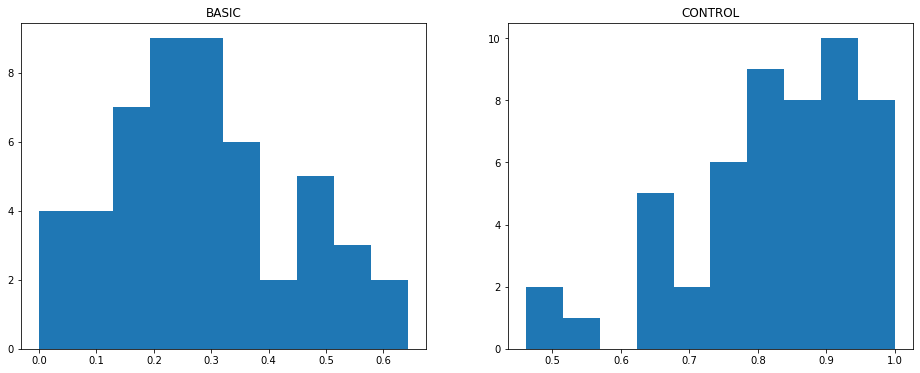

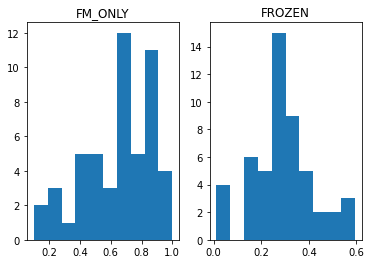

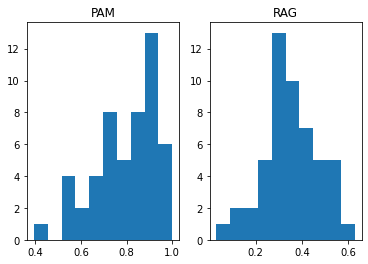

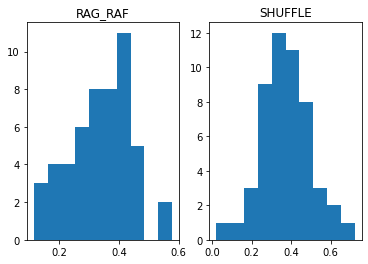

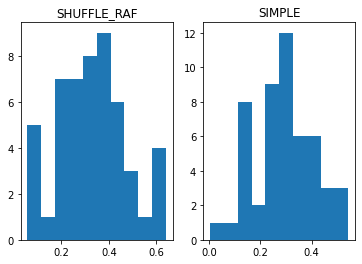

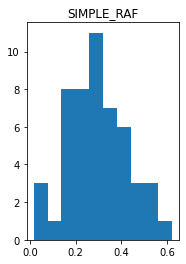

In [194]:
dpi = 300
study_type = 0
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
box_plot(df, study_type, savefig=True, dpi=dpi)
response_histograms(df, 10)

### Study 1

Perceived realism.

**Note**:
Ratings are min-max normalized per subject.

,mean,std
condition,,
BASIC,0.635573,0.280864
CONTROL,0.383148,0.319881
FM_ONLY,0.495426,0.313030
FROZEN,0.594353,0.265677
PAM,0.380236,0.313012
RAG,0.571733,0.258197
RAG_RAF,0.513825,0.273695
SHUFFLE,0.554518,0.264120
SHUFFLE_RAF,0.461906,0.281960


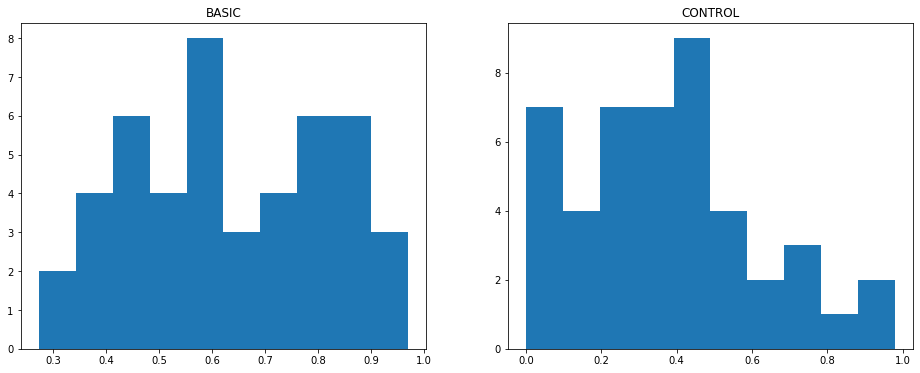

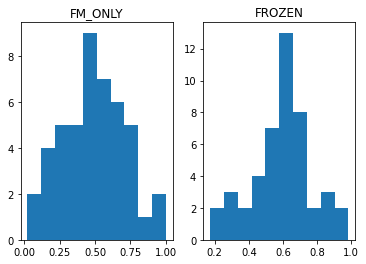

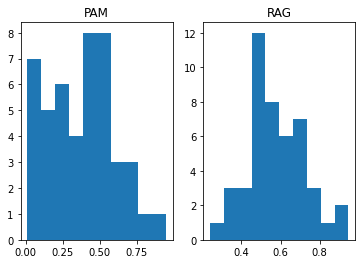

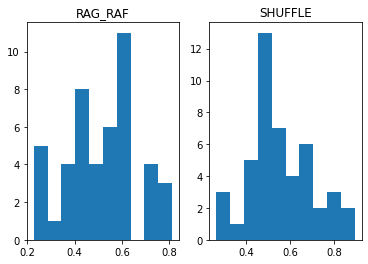

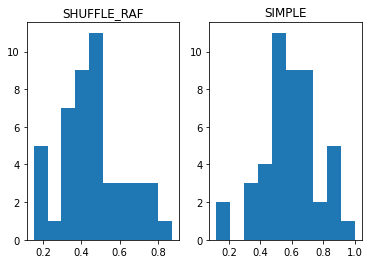

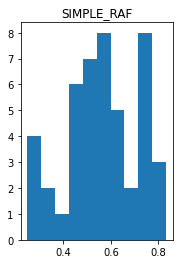

In [195]:
study_type = 1
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = df.reset_index(drop=True)

display(get_summary(df))
box_plot(df, study_type, savefig=True, dpi=dpi)
response_histograms(df, 10)

Condition: BASIC


,W,pval,normal
rating,0.964394,0.169722,True


Condition: CONTROL


,W,pval,normal
rating,0.964787,0.175752,True


Condition: FM_ONLY


,W,pval,normal
rating,0.98944,0.947812,True


Condition: FROZEN


,W,pval,normal
rating,0.973906,0.383736,True


Condition: PAM


,W,pval,normal
rating,0.971008,0.301811,True


Condition: RAG


,W,pval,normal
rating,0.980547,0.628389,True


Condition: RAG_RAF


,W,pval,normal
rating,0.975532,0.436773,True


Condition: SHUFFLE


,W,pval,normal
rating,0.971606,0.317404,True


Condition: SHUFFLE_RAF


,W,pval,normal
rating,0.973068,0.358385,True


Condition: SIMPLE


,W,pval,normal
rating,0.979509,0.586012,True


Condition: SIMPLE_RAF


,W,pval,normal
rating,0.972347,0.337662,True


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,condition,10,450,10.902582,1.099053e-16,0.000028,0.195028,0.220987,False,0.00004,1.645004e-57


,Source,W,ddof1,ddof2,F,p-unc
Friedman,condition,0.162318,9.956522,448.043478,8.719696,4.680287e-13


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,BASIC,CONTROL,True,True,4.702836,45.0,two-sided,0.000025,0.001351,bonf,850.493,1.130040
3,condition,BASIC,PAM,True,True,4.728441,45.0,two-sided,0.000023,0.001242,bonf,919.003,1.189960
5,condition,BASIC,RAG_RAF,True,True,4.388283,45.0,two-sided,0.000068,0.003754,bonf,332.647,0.699784
6,condition,BASIC,SHUFFLE,True,True,3.604177,45.0,two-sided,0.000780,0.042882,bonf,36.545,0.475276
7,condition,BASIC,SHUFFLE_RAF,True,True,5.365670,45.0,two-sided,0.000003,0.000148,bonf,6586.03,0.955670
10,condition,CONTROL,FM_ONLY,True,True,-3.679146,45.0,two-sided,0.000623,0.034259,bonf,44.701,-0.464905
11,condition,CONTROL,FROZEN,True,True,-3.768258,45.0,two-sided,0.000476,0.026168,bonf,56.963,-0.967982
13,condition,CONTROL,RAG,True,True,-4.089356,45.0,two-sided,0.000176,0.009704,bonf,139.831,-0.919501
17,condition,CONTROL,SIMPLE,True,True,-4.238156,45.0,two-sided,0.000110,0.006066,bonf,214.53,-0.971708
20,condition,FM_ONLY,PAM,True,True,3.554408,45.0,two-sided,0.000904,0.049717,bonf,32.011,0.493552


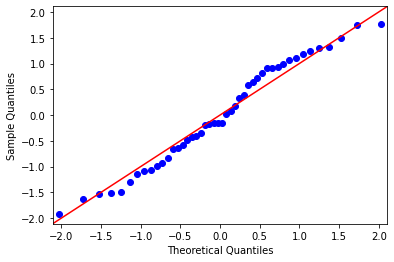

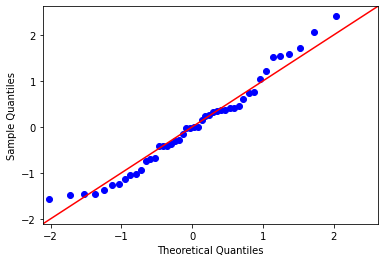

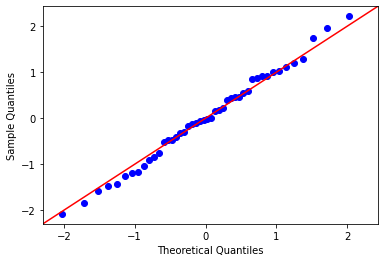

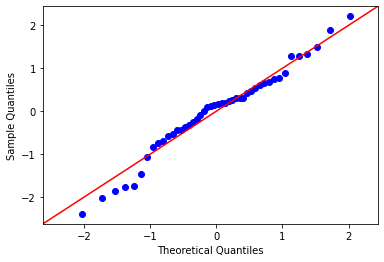

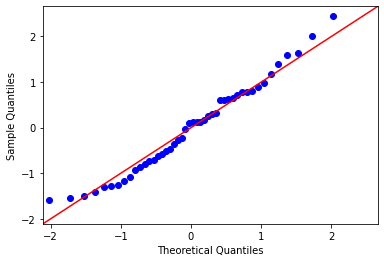

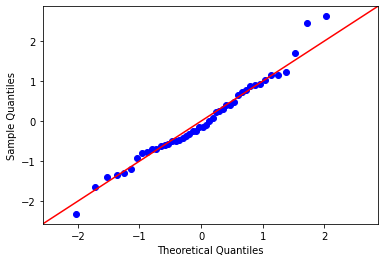

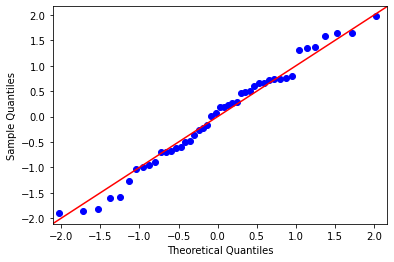

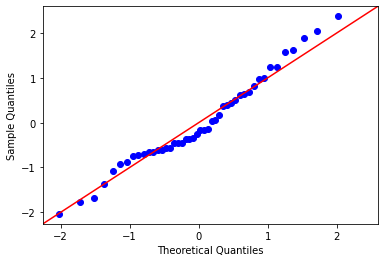

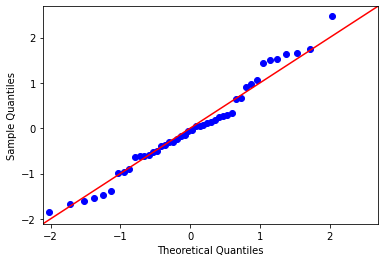

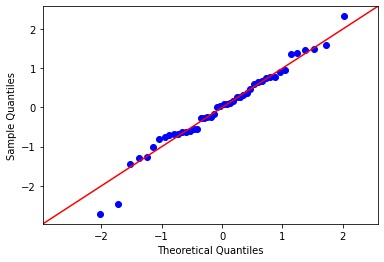

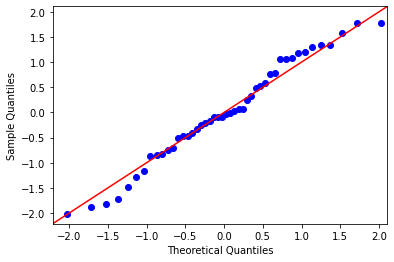

In [181]:
dpi=300

study_type = 1
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = extract_condition(df)
df = min_max_norm(df)
df = anova_prep(df)
df = df.reset_index(drop=True)

# ANOVA with repeated measures notes.

for condition in df['condition'].unique():
    print(f"Condition: {condition}")
    display(pg.normality(df[df['condition']==condition]['rating']))
    sm.qqplot(df[df['condition']==condition]['rating'], fit=True, line="45")
    plt.savefig(f"./figs/qq_studytype_{study_type}_{condition}.png", dpi=dpi)

display(df.rm_anova(dv='rating', within='condition', subject='subjectNo', correction=True))
display(pg.friedman(data=df, dv='rating', within='condition', subject='subjectNo', method='f'))

tmp = df.pairwise_ttests(dv='rating', within='condition', subject='subjectNo', padjust='bonf')
display(tmp[tmp['p-corr'] <= 0.05])
# display(tmp)

### Explorations

In [269]:
study_type = 0
df = load('./prolific/*.csv')
df = isolate_study(df, study_type)
df = extract_trials(df)
df = normalize_slider(df)
df = extract_subject(df)
df = min_max_norm(df)
df = extract_condition(df)

print(f"Total N = {get_num_subjects(df)}")
filter_by_control(df, 0.25)
# max_time_elapsed(df).mean()


# df = extract_condition(df)
# df = min_max_norm(df)
# df = anova_prep(df)
# df = df.reset_index(drop=True)
# df = average_condition_rating_within_subject(df)

Total N = 51
N = 40
8


In [252]:
.37*60

22.2

In [188]:
tmp = df.groupby(['subjectNo', 'condition'])['response'].mean()
tmp = tmp.unstack()



In [189]:
tmp.columns

Index(['BASIC', 'CONTROL', 'FM ONLY', 'FROZEN', 'PAM', 'RAG', 'RAG RAF',
       'SHUFFLE', 'SHUFFLE RAF', 'SIMPLE', 'SIMPLE RAF'],
      dtype='object')